In [1]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import Counter
import cv2
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import make_classification
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import (SMOTE, BorderlineSMOTE, SVMSMOTE,
                                    SMOTENC,ADASYN, KMeansSMOTE)
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from imblearn.base import BaseSampler
from fastai import *
from fastai.vision import *
import imageio
from torchvision import transforms
from torchvision.utils import save_image
import PIL

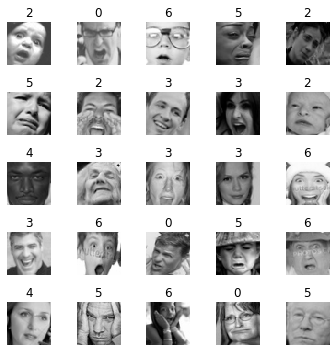

In [2]:
path = datapath4file('kaggle_fer_challenge_db')
tfms = get_transforms()
data = (ImageList.from_folder(path)
        .split_none()
        .label_from_folder()
        .transform(tfms, size=48)
        .databunch()).normalize(imagenet_stats)
data.show_batch(row=3, figsize=(5,5))

In [3]:
names = []
shapes = []
anger, happiness, sadness, neutral, disgust, fear, surprise = 0, 0, 0, 0, 0, 0, 0


for i in data.train_ds:
    # get the Image tensor to numpy array
    my_tensor = i[0].data.cpu().detach().numpy()
    # get batch, line, cols of the array
    batch, line, cols = my_tensor.shape
    # reshape
    to_be_used_in_resample = my_tensor.reshape(1,-1)
    # append the reshaped numpy array 
    shapes.append(to_be_used_in_resample)
    names.append(int(str(i[1])[-1]))
    if str(i[1]).endswith('0'):
        anger += 1
    if str(i[1]).endswith('1'):
        disgust += 1
    if str(i[1]).endswith('2'):
        fear += 1
    if str(i[1]).endswith('3'):
        happiness  += 1
    if str(i[1]).endswith('4'):
        neutral += 1
    if str(i[1]).endswith('5'):
        sadness += 1
    if str(i[1]).endswith('6'):
        surprise += 1


print('TRAIN SET')        
print('anger: ' + str(anger))
print('disgust: ' + str(disgust))
print('fear: ' + str(fear))
print('happiness: ' + str(happiness))
print('neutral: ' + str(neutral))
print('sadness: ' + str(sadness))
print('surprise: ' + str(surprise))

TRAIN SET
anger: 4953
disgust: 547
fear: 5121
happiness: 8989
neutral: 6198
sadness: 6077
surprise: 4002


In [41]:
X, y = np.concatenate(shapes), names
feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df['y'] = y
df['label'] = df['y'].apply(lambda i: str(i))
X, y = None, None
print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (35887, 6914)


In [42]:
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

In [43]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.318772 0.100503 0.092225]


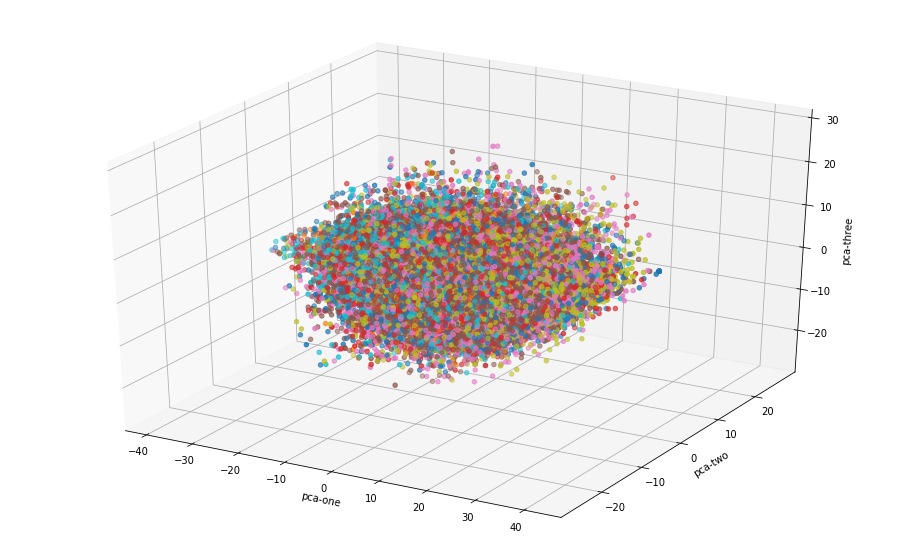

In [44]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df.loc[rndperm,:]["pca-one"], 
    ys=df.loc[rndperm,:]["pca-two"], 
    zs=df.loc[rndperm,:]["pca-three"], 
    c=df.loc[rndperm,:]["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [45]:
N = 10000
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.317852 0.102367 0.09018 ]


In [46]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 8.579s...
[t-SNE] Computed neighbors for 10000 samples in 1338.170s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 4.030444
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.395111
[t-SNE] KL divergence after 300 iterations: 3.396900
t-SNE done! Time elaps

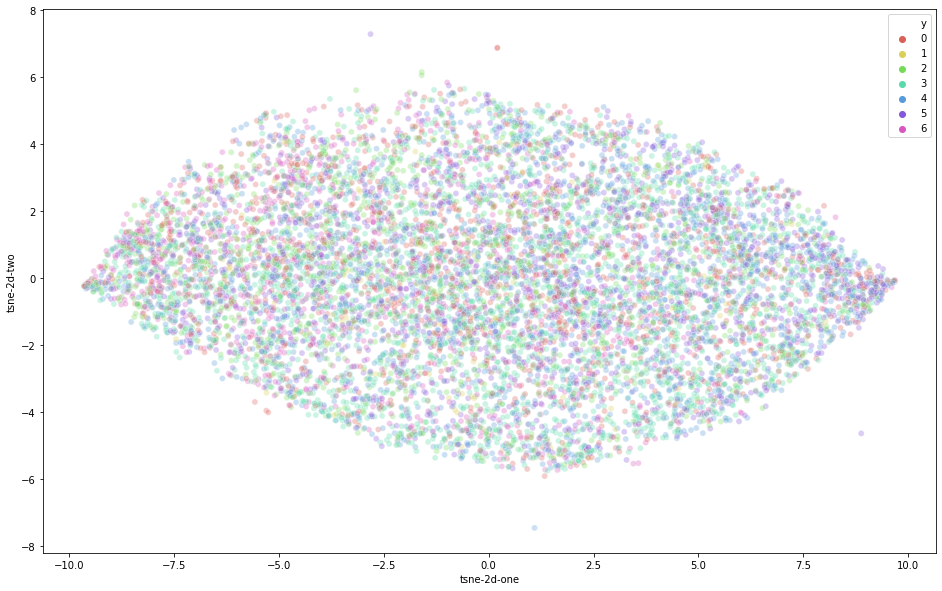

In [47]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 7),
    data=df_subset,
    legend="full",
    alpha=0.3
)

In [48]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(data_subset)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.8729804754257202


In [49]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_50)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 25.584092378616333 seconds


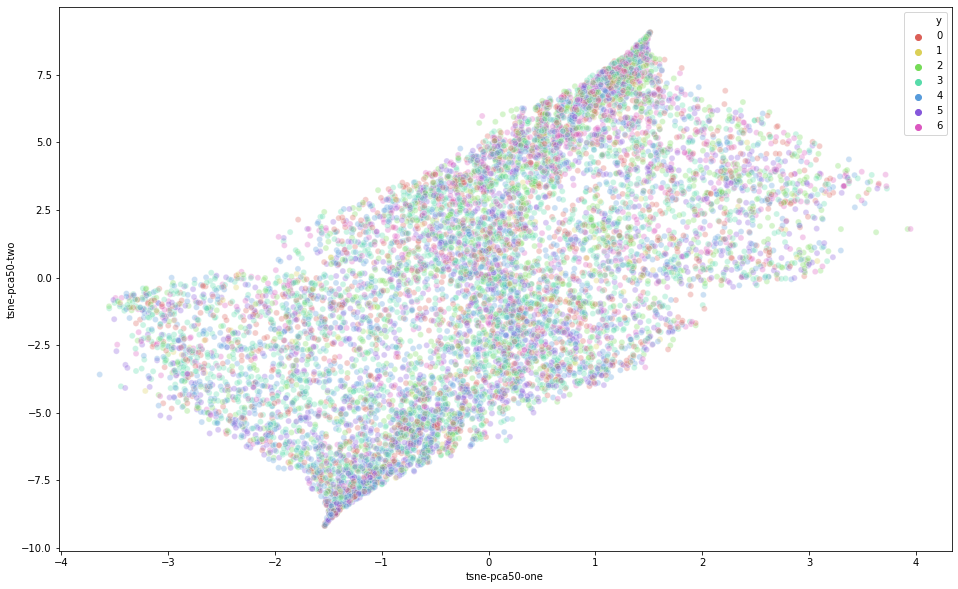

In [50]:
df_subset['tsne-pca50-one'] = tsne_pca_results[:,0]
df_subset['tsne-pca50-two'] = tsne_pca_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-pca50-one", y="tsne-pca50-two",
    hue="y",
    palette=sns.color_palette("hls", 7),
    data=df_subset,
    legend="full",
    alpha=0.3
)

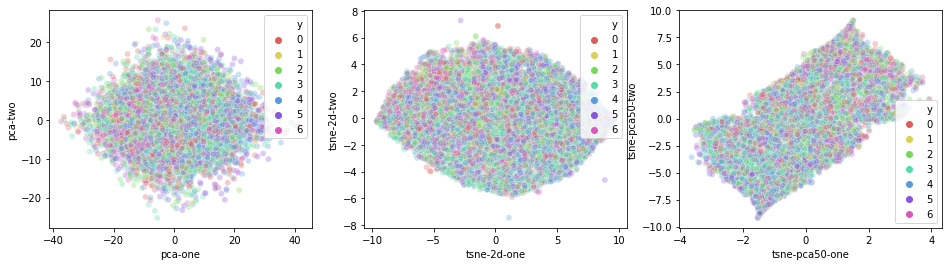

In [51]:
df_subset['tsne-pca50-one'] = tsne_pca_results[:,0]
df_subset['tsne-pca50-two'] = tsne_pca_results[:,1]
plt.figure(figsize=(16,4))
ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 7),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 7),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)
ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(
    x="tsne-pca50-one", y="tsne-pca50-two",
    hue="y",
    palette=sns.color_palette("hls", 7),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax3
)


In [6]:
from imblearn.over_sampling import RandomOverSampler
X, y = np.concatenate(shapes), names
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)
print(X_ros.shape[0] - X.shape[0], 'new random picked points')
print(str(X_ros.shape) + str(X.shape))

27036 new random picked points
(62923, 6912)(35887, 6912)


In [7]:
anger, happiness, sadness, neutral, disgust, fear, surprise = 0, 0, 0, 0, 0, 0, 0
numbers = []
for x in range(len(X_ros)):
        path = str(datapath4file('resampled_random_db')) + '/' + str(y_ros[x]) + '/' + str(x) + '.png'
        a = X_ros[x].reshape((2304, 3))
        a = a.reshape((48, 48, 3))
        a = a.reshape(3, 48, 48)
        b = np2model_tensor(a)
        save_image(b, path)
        if str(y_ros[x]).endswith('0'):
            anger += 1
        if str(y_ros[x]).endswith('1'):
            disgust += 1
        if str(y_ros[x]).endswith('2'):
            fear += 1
        if str(y_ros[x]).endswith('3'):
            happiness  += 1
        if str(y_ros[x]).endswith('4'):
            neutral += 1
        if str(y_ros[x]).endswith('5'):
            sadness += 1
        if str(y_ros[x]).endswith('6'):
            surprise += 1
        
print('TRAIN SET')        
print('anger: ' + str(anger))
print('disgust: ' + str(disgust))
print('fear: ' + str(fear))
print('happiness: ' + str(happiness))
print('neutral: ' + str(neutral))
print('sadness: ' + str(sadness))
print('surprise: ' + str(surprise))

TRAIN SET
anger: 8989
disgust: 8989
fear: 8989
happiness: 8989
neutral: 8989
sadness: 8989
surprise: 8989


In [54]:
feat_cols = [ 'pixel'+str(i) for i in range(X_ros.shape[1]) ]
df = pd.DataFrame(X_ros,columns=feat_cols)
df['y'] = y_ros
df['label'] = df['y'].apply(lambda i: str(i))
X_ros, y_ros = None, None
print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (62923, 6914)


In [55]:
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

In [56]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.319674 0.10198  0.093392]


In [57]:
N = 10000
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.320055 0.103325 0.092157]


In [58]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 8.629s...
[t-SNE] Computed neighbors for 10000 samples in 1328.834s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 4.477960
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.534149
[t-SNE] KL divergence after 300 iterations: 3.308573
t-SNE done! Time elaps

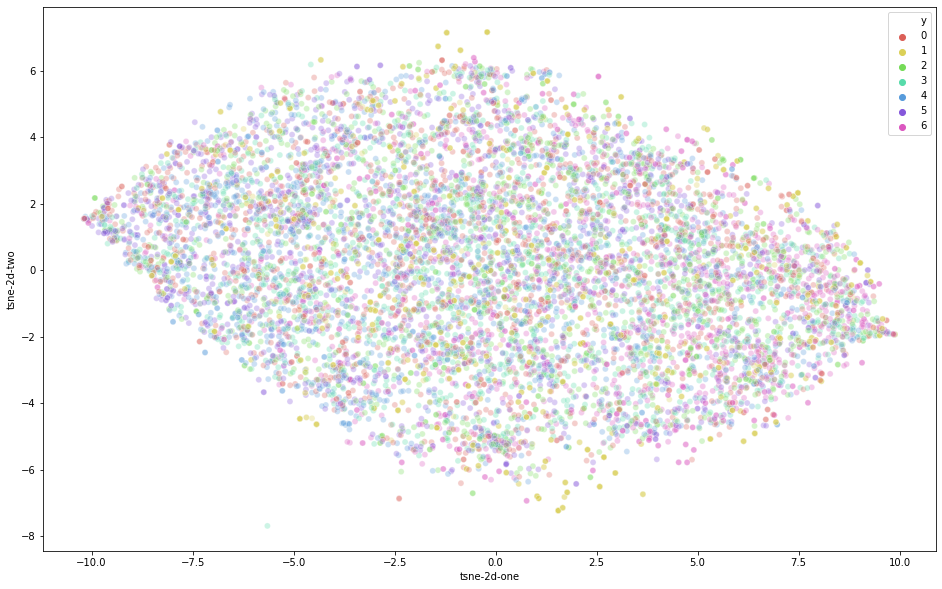

In [59]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 7),
    data=df_subset,
    legend="full",
    alpha=0.3
)

In [60]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(data_subset)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.8738317489624023


In [61]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_50)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 24.673330307006836 seconds


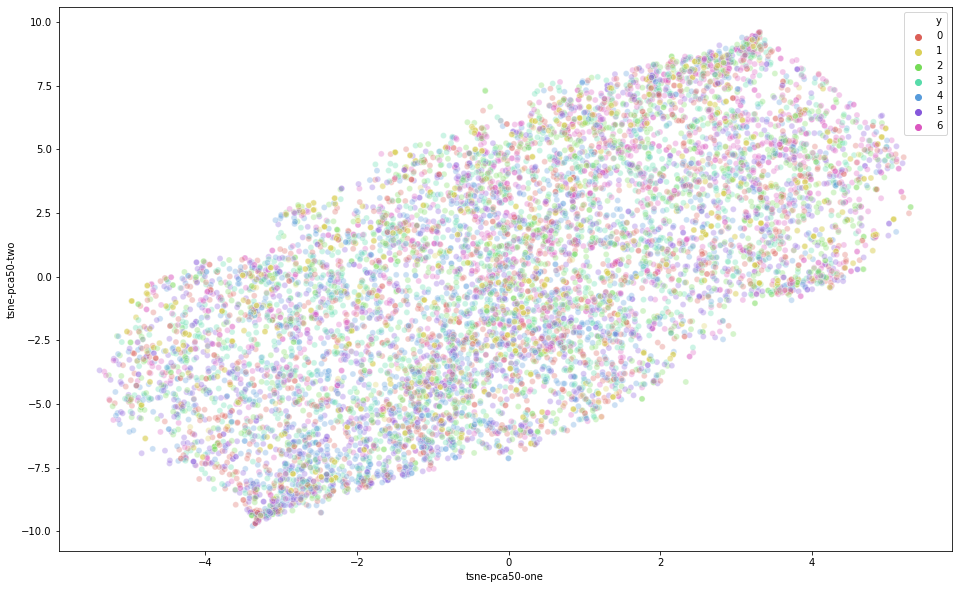

In [62]:
df_subset['tsne-pca50-one'] = tsne_pca_results[:,0]
df_subset['tsne-pca50-two'] = tsne_pca_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-pca50-one", y="tsne-pca50-two",
    hue="y",
    palette=sns.color_palette("hls", 7),
    data=df_subset,
    legend="full",
    alpha=0.3
)

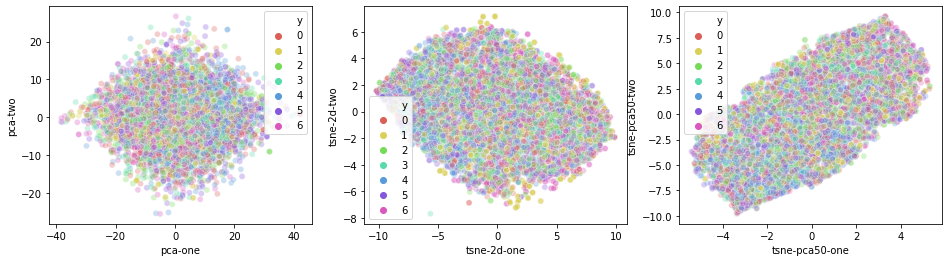

In [63]:
plt.figure(figsize=(16,4))
ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 7),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 7),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)
ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(
    x="tsne-pca50-one", y="tsne-pca50-two",
    hue="y",
    palette=sns.color_palette("hls", 7),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax3
)


In [4]:
time_start = time.time()
X, y = np.concatenate(shapes), names
smote = SMOTE()
X_ros, y_ros = smote.fit_sample(X, y)
print('Time elapsed: {} seconds'.format(time.time()-time_start))

Time elapsed: 1923.6659865379333 seconds


In [5]:
anger, happiness, sadness, neutral, disgust, fear, surprise = 0, 0, 0, 0, 0, 0, 0
for x in range(len(X_ros)):
        path = str(datapath4file('resampled_smote_db')) + '/' + str(y_ros[x]) + '/' + str(x) + '.png'
        a = X_ros[x].reshape((2304, 3))
        a = a.reshape((48, 48, 3))
        a = a.reshape(3, 48, 48)
        b = np2model_tensor(a)
        save_image(b, path)
        if str(y_ros[x]).endswith('0'):
            anger += 1
        if str(y_ros[x]).endswith('1'):
            disgust += 1
        if str(y_ros[x]).endswith('2'):
            fear += 1
        if str(y_ros[x]).endswith('3'):
            happiness  += 1
        if str(y_ros[x]).endswith('4'):
            neutral += 1
        if str(y_ros[x]).endswith('5'):
            sadness += 1
        if str(y_ros[x]).endswith('6'):
            surprise += 1
        
print('TRAIN SET')        
print('anger: ' + str(anger))
print('disgust: ' + str(disgust))
print('fear: ' + str(fear))
print('happiness: ' + str(happiness))
print('neutral: ' + str(neutral))
print('sadness: ' + str(sadness))
print('surprise: ' + str(surprise))

TRAIN SET
anger: 8989
disgust: 8989
fear: 8989
happiness: 8989
neutral: 8989
sadness: 8989
surprise: 8989


In [66]:
feat_cols = [ 'pixel'+str(i) for i in range(X_ros.shape[1]) ]
df = pd.DataFrame(X_ros,columns=feat_cols)
df['y'] = y_ros
df['label'] = df['y'].apply(lambda i: str(i))
X_ros, y_ros = None, None
print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (62923, 6914)


In [67]:
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

In [68]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.354563 0.10455  0.096399]


In [69]:
N = 10000
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.354911 0.105782 0.095628]


In [70]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 8.620s...
[t-SNE] Computed neighbors for 10000 samples in 1339.142s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 188.286320
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.479301
[t-SNE] KL divergence after 300 iterations: 3.199979
t-SNE done! Time ela

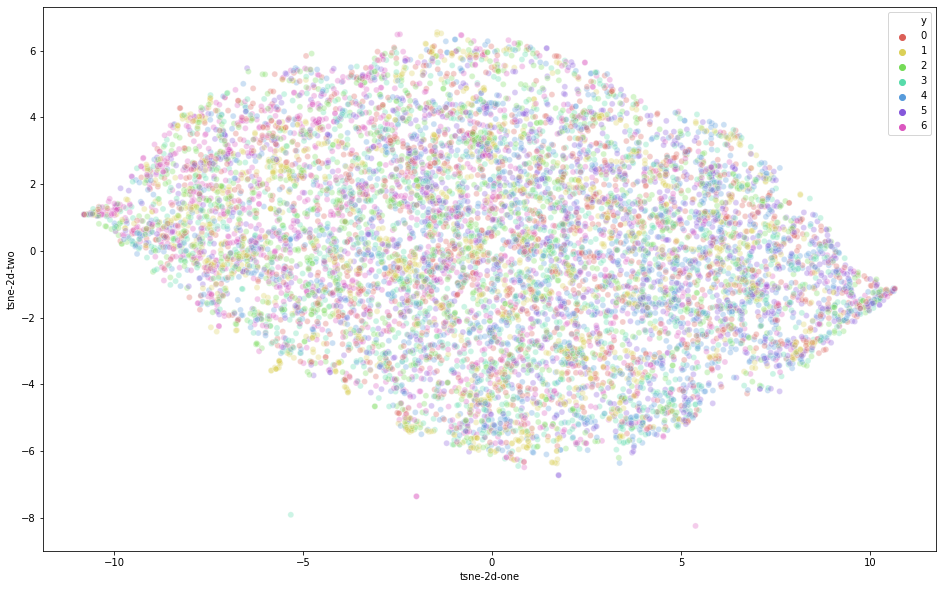

In [71]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 7),
    data=df_subset,
    legend="full",
    alpha=0.3
)

In [72]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(data_subset)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.8882548809051514


In [73]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_50)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 23.51164984703064 seconds


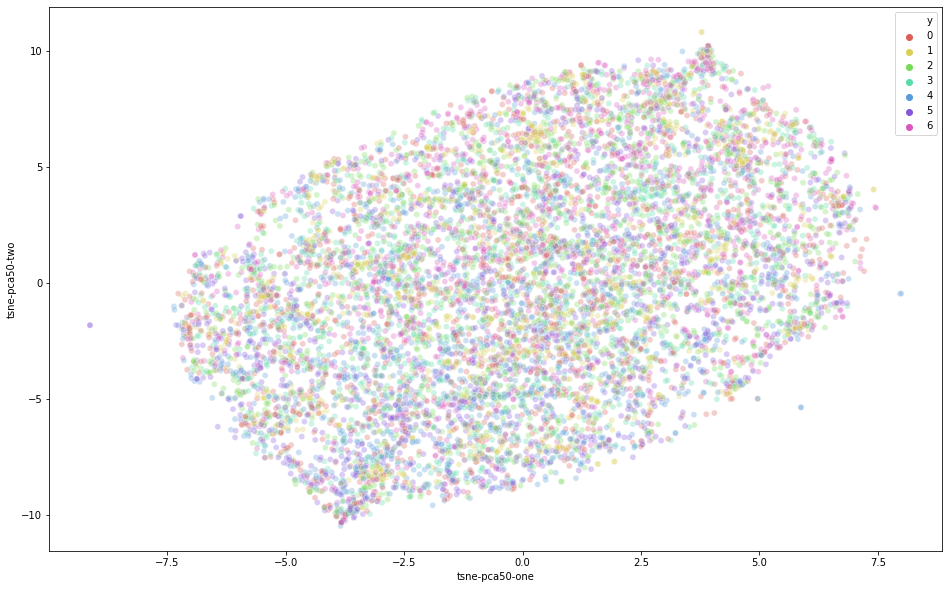

In [74]:
df_subset['tsne-pca50-one'] = tsne_pca_results[:,0]
df_subset['tsne-pca50-two'] = tsne_pca_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-pca50-one", y="tsne-pca50-two",
    hue="y",
    palette=sns.color_palette("hls", 7),
    data=df_subset,
    legend="full",
    alpha=0.3
)

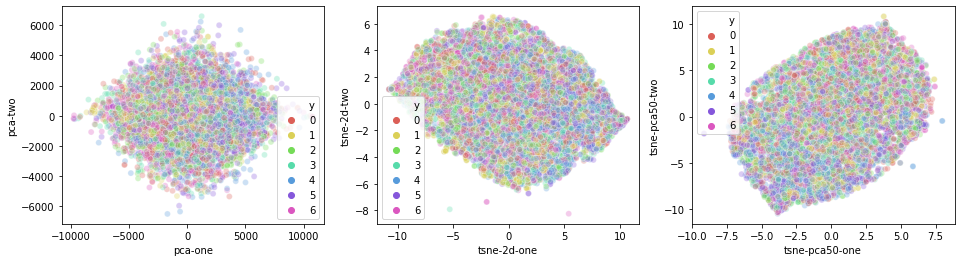

In [75]:
plt.figure(figsize=(16,4))
ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 7),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 7),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)
ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(
    x="tsne-pca50-one", y="tsne-pca50-two",
    hue="y",
    palette=sns.color_palette("hls", 7),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax3
)


In [4]:
time_start = time.time()
X, y = np.concatenate(shapes), names
ada = ADASYN()
X_ros, y_ros = ada.fit_sample(X, y)
print('Time elapsed: {} seconds'.format(time.time()-time_start))

Time elapsed: 15962.731317281723 seconds


In [5]:
anger, happiness, sadness, neutral, disgust, fear, surprise = 0, 0, 0, 0, 0, 0, 0
for x in range(len(X_ros)):
        path = str(datapath4file('resampled_adasyn_db')) + '/' + str(y_ros[x]) + '/' + str(x) + '.png'
        a = X_ros[x].reshape((2304, 3))
        a = a.reshape((48, 48, 3))
        a = a.reshape(3, 48, 48)
        b = np2model_tensor(a)
        save_image(b, path)
        if str(y_ros[x]).endswith('0'):
            anger += 1
        if str(y_ros[x]).endswith('1'):
            disgust += 1
        if str(y_ros[x]).endswith('2'):
            fear += 1
        if str(y_ros[x]).endswith('3'):
            happiness  += 1
        if str(y_ros[x]).endswith('4'):
            neutral += 1
        if str(y_ros[x]).endswith('5'):
            sadness += 1
        if str(y_ros[x]).endswith('6'):
            surprise += 1
        
print('TRAIN SET')        
print('anger: ' + str(anger))
print('disgust: ' + str(disgust))
print('fear: ' + str(fear))
print('happiness: ' + str(happiness))
print('neutral: ' + str(neutral))
print('sadness: ' + str(sadness))
print('surprise: ' + str(surprise))

TRAIN SET
anger: 9686
disgust: 9003
fear: 9928
happiness: 8989
neutral: 9594
sadness: 8320
surprise: 9402


In [78]:
feat_cols = [ 'pixel'+str(i) for i in range(X_ros.shape[1]) ]
df = pd.DataFrame(X_ros,columns=feat_cols)
df['y'] = y_ros
df['label'] = df['y'].apply(lambda i: str(i))
X_ros, y_ros = None, None
print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (65064, 6914)


In [79]:
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

In [80]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.353299 0.105193 0.097146]


In [81]:
N = 10000
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.352785 0.103732 0.098505]


In [82]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 8.647s...
[t-SNE] Computed neighbors for 10000 samples in 1343.212s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 224.505403
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.692657
[t-SNE] KL divergence after 300 iterations: 3.199082
t-SNE done! Time ela

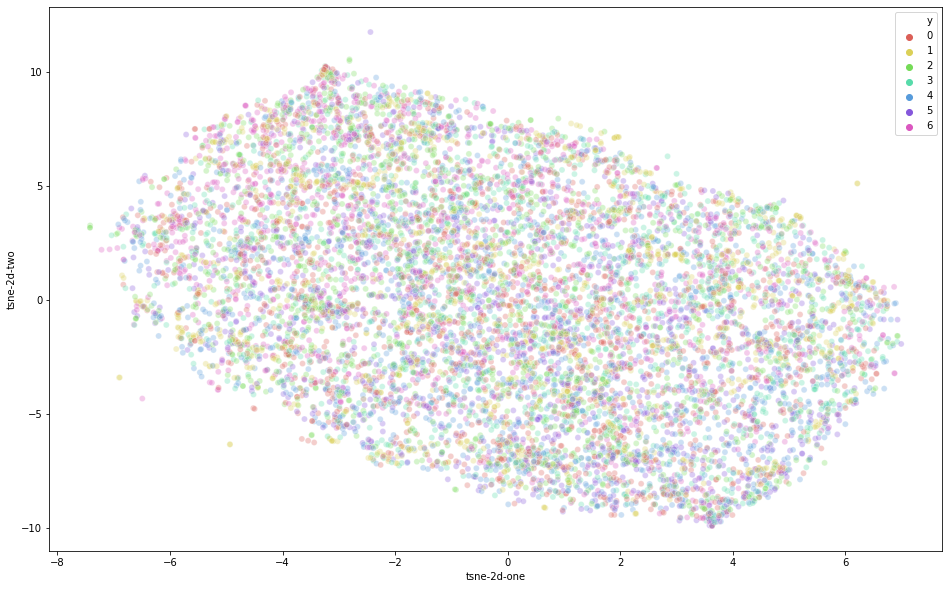

In [83]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 7),
    data=df_subset,
    legend="full",
    alpha=0.3
)

In [84]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(data_subset)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.8879623413085938


In [85]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_50)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 19.39977240562439 seconds


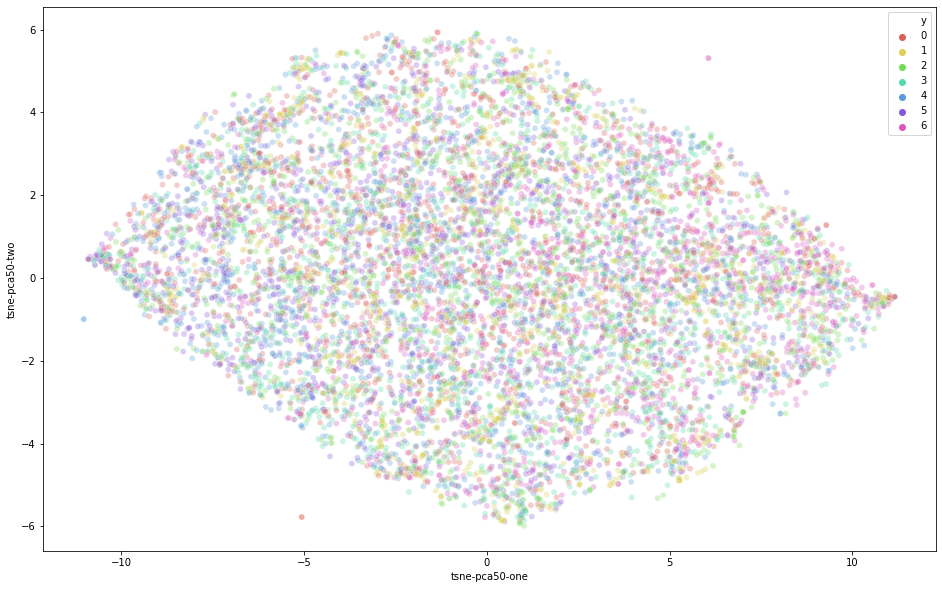

In [86]:
df_subset['tsne-pca50-one'] = tsne_pca_results[:,0]
df_subset['tsne-pca50-two'] = tsne_pca_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-pca50-one", y="tsne-pca50-two",
    hue="y",
    palette=sns.color_palette("hls", 7),
    data=df_subset,
    legend="full",
    alpha=0.3
)

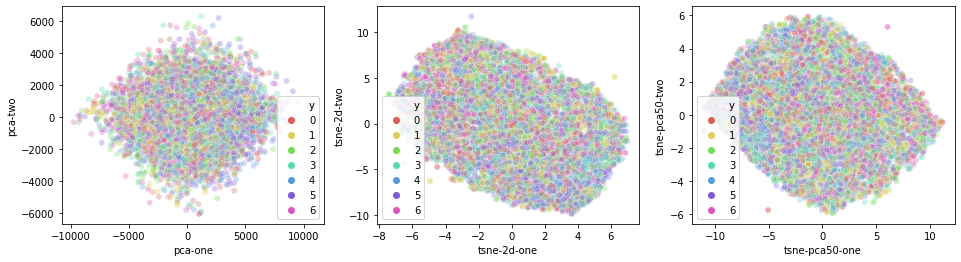

In [87]:
plt.figure(figsize=(16,4))
ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 7),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 7),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)
ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(
    x="tsne-pca50-one", y="tsne-pca50-two",
    hue="y",
    palette=sns.color_palette("hls", 7),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax3
)


In [6]:
X, y = np.concatenate(shapes), names
smt = SMOTETomek()
X_ros, y_ros, = smt.fit_resample(X, y)

In [7]:
anger, happiness, sadness, neutral, disgust, fear, surprise = 0, 0, 0, 0, 0, 0, 0
for x in range(len(X_ros)):
        path = str(datapath4file('resampled_smotetomek_db')) + '/' + str(y_ros[x]) + '/' + str(x) + '.png'
        a = X_ros[x].reshape((2304, 3))
        a = a.reshape((48, 48, 3))
        a = a.reshape(3, 48, 48)
        b = np2model_tensor(a)
        save_image(b, path)
        if str(y_ros[x]).endswith('0'):
            anger += 1
        if str(y_ros[x]).endswith('1'):
            disgust += 1
        if str(y_ros[x]).endswith('2'):
            fear += 1
        if str(y_ros[x]).endswith('3'):
            happiness  += 1
        if str(y_ros[x]).endswith('4'):
            neutral += 1
        if str(y_ros[x]).endswith('5'):
            sadness += 1
        if str(y_ros[x]).endswith('6'):
            surprise += 1
        
print('DATASET')        
print('anger: ' + str(anger))
print('disgust: ' + str(disgust))
print('fear: ' + str(fear))
print('happiness: ' + str(happiness))
print('neutral: ' + str(neutral))
print('sadness: ' + str(sadness))
print('surprise: ' + str(surprise))

DATASET
anger: 8975
disgust: 8989
fear: 8950
happiness: 8964
neutral: 8961
sadness: 8960
surprise: 8984


In [8]:
feat_cols = [ 'pixel'+str(i) for i in range(X_ros.shape[1]) ]
df = pd.DataFrame(X_ros,columns=feat_cols)
df['y'] = y_ros
df['label'] = df['y'].apply(lambda i: str(i))
X_ros, y_ros = None, None
print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (62783, 6914)


In [9]:
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

In [10]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.358752 0.102498 0.096027]


In [11]:
N = 10000
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.359261 0.102079 0.094076]


In [12]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 8.710s...
[t-SNE] Computed neighbors for 10000 samples in 1549.098s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 659.998366
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.354950
[t-SNE] KL divergence after 300 iterations: 3.245088
t-SNE done! Time ela

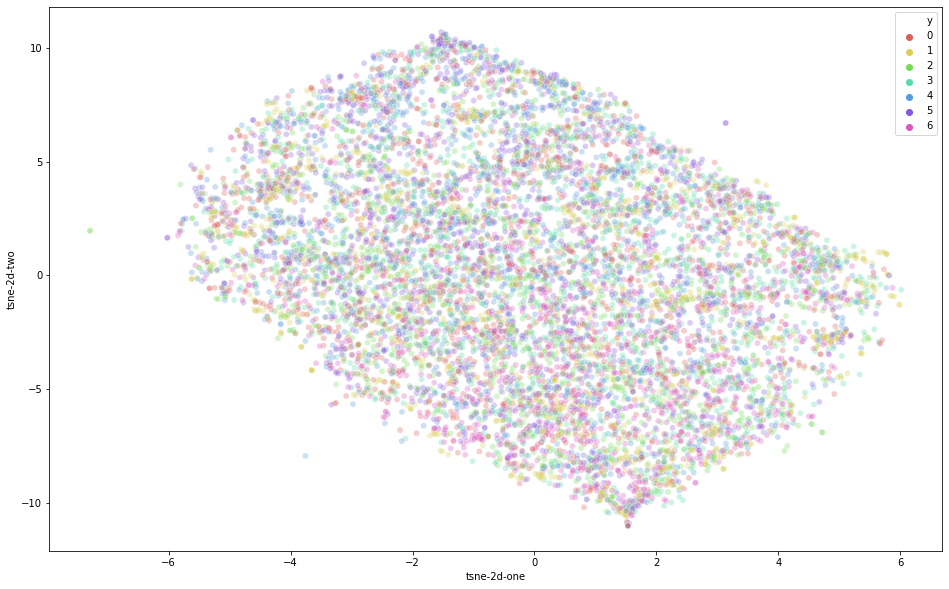

In [13]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 7),
    data=df_subset,
    legend="full",
    alpha=0.3
)

In [14]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(data_subset)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.8883185982704163


In [15]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_50)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 23.025714874267578 seconds


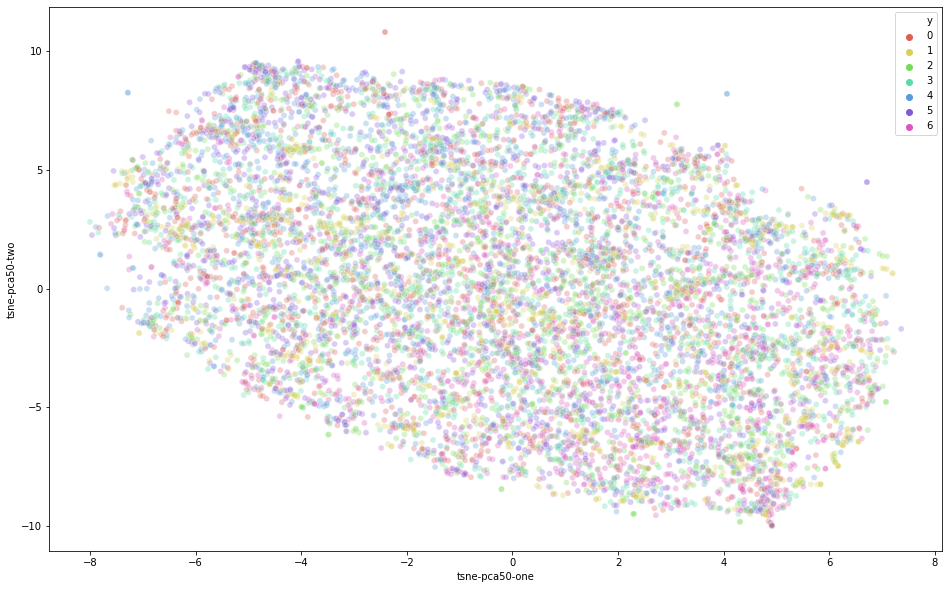

In [16]:
df_subset['tsne-pca50-one'] = tsne_pca_results[:,0]
df_subset['tsne-pca50-two'] = tsne_pca_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-pca50-one", y="tsne-pca50-two",
    hue="y",
    palette=sns.color_palette("hls", 7),
    data=df_subset,
    legend="full",
    alpha=0.3
)

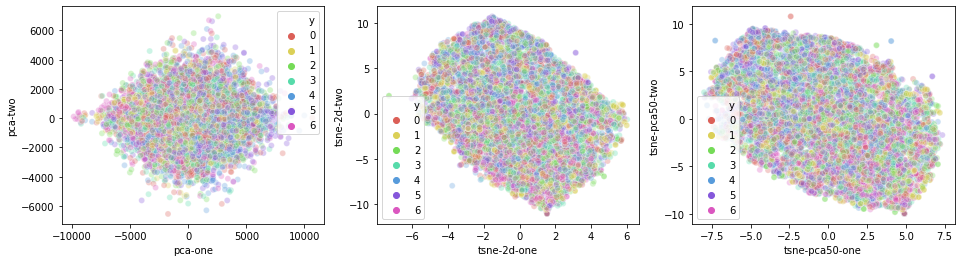

In [17]:
plt.figure(figsize=(16,4))
ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 7),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 7),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)
ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(
    x="tsne-pca50-one", y="tsne-pca50-two",
    hue="y",
    palette=sns.color_palette("hls", 7),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax3
)

In [4]:
time_start = time.time()
X, y = np.concatenate(shapes), names
smt = KMeansSMOTE()
X_ros, y_ros, = smt.fit_resample(X, y)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 134.31019616127014 seconds


In [5]:
anger, happiness, sadness, neutral, disgust, fear, surprise = 0, 0, 0, 0, 0, 0, 0
for x in range(len(X_ros)):
        path = str(datapath4file('resampled_kmeanssmote_db')) + '/' + str(y_ros[x]) + '/' + str(x) + '.png'
        a = X_ros[x].reshape((2304, 3))
        a = a.reshape((48, 48, 3))
        a = a.reshape(3, 48, 48)
        b = np2model_tensor(a)
        save_image(b, path)
        if str(y_ros[x]).endswith('0'):
            anger += 1
        if str(y_ros[x]).endswith('1'):
            disgust += 1
        if str(y_ros[x]).endswith('2'):
            fear += 1
        if str(y_ros[x]).endswith('3'):
            happiness  += 1
        if str(y_ros[x]).endswith('4'):
            neutral += 1
        if str(y_ros[x]).endswith('5'):
            sadness += 1
        if str(y_ros[x]).endswith('6'):
            surprise += 1
        
print('DATASET')        
print('anger: ' + str(anger))
print('disgust: ' + str(disgust))
print('fear: ' + str(fear))
print('happiness: ' + str(happiness))
print('neutral: ' + str(neutral))
print('sadness: ' + str(sadness))
print('surprise: ' + str(surprise))

DATASET
anger: 8995
disgust: 0
fear: 0
happiness: 8989
neutral: 0
sadness: 8995
surprise: 8990


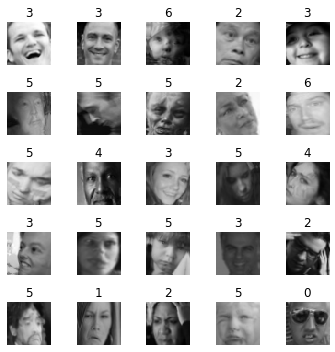

In [2]:
path = datapath4file('resampled_smote_db')
tfms = get_transforms()
data = (ImageList.from_folder(path)
        .split_none()
        .label_from_folder()
        .transform(tfms, size=48)
        .databunch()).normalize(imagenet_stats)
data.show_batch(row=3, figsize=(5,5))

In [3]:
names = []
shapes = []
anger, happiness, sadness, neutral, disgust, fear, surprise = 0, 0, 0, 0, 0, 0, 0


for i in data.train_ds:
    # get the Image tensor to numpy array
    my_tensor = i[0].data.cpu().detach().numpy()
    # get batch, line, cols of the array
    batch, line, cols = my_tensor.shape
    # reshape
    to_be_used_in_resample = my_tensor.reshape(1,-1)
    # append the reshaped numpy array 
    shapes.append(to_be_used_in_resample)
    names.append(int(str(i[1])[-1]))
    if str(i[1]).endswith('0'):
        anger += 1
    if str(i[1]).endswith('1'):
        disgust += 1
    if str(i[1]).endswith('2'):
        fear += 1
    if str(i[1]).endswith('3'):
        happiness  += 1
    if str(i[1]).endswith('4'):
        neutral += 1
    if str(i[1]).endswith('5'):
        sadness += 1
    if str(i[1]).endswith('6'):
        surprise += 1


print('TRAIN SET')        
print('anger: ' + str(anger))
print('disgust: ' + str(disgust))
print('fear: ' + str(fear))
print('happiness: ' + str(happiness))
print('neutral: ' + str(neutral))
print('sadness: ' + str(sadness))
print('surprise: ' + str(surprise))

TRAIN SET
anger: 9653
disgust: 9693
fear: 10678
happiness: 8989
neutral: 11366
sadness: 10646
surprise: 11130


In [ ]:
time_start = time.time()
X, y = np.concatenate(shapes), names
ada = TomekLinks()
X_ros, y_ros = ada.fit_sample(X, y)
print('Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:
anger, happiness, sadness, neutral, disgust, fear, surprise = 0, 0, 0, 0, 0, 0, 0
for x in range(len(X_ros)):
        path = str(datapath4file('resampled_kmeanssmote_db')) + '/' + str(y_ros[x]) + '/' + str(x) + '.png'
        a = X_ros[x].reshape((2304, 3))
        a = a.reshape((48, 48, 3))
        a = a.reshape(3, 48, 48)
        b = np2model_tensor(a)
        save_image(b, path)
        if str(y_ros[x]).endswith('0'):
            anger += 1
        if str(y_ros[x]).endswith('1'):
            disgust += 1
        if str(y_ros[x]).endswith('2'):
            fear += 1
        if str(y_ros[x]).endswith('3'):
            happiness  += 1
        if str(y_ros[x]).endswith('4'):
            neutral += 1
        if str(y_ros[x]).endswith('5'):
            sadness += 1
        if str(y_ros[x]).endswith('6'):
            surprise += 1
        
print('DATASET')        
print('anger: ' + str(anger))
print('disgust: ' + str(disgust))
print('fear: ' + str(fear))
print('happiness: ' + str(happiness))
print('neutral: ' + str(neutral))
print('sadness: ' + str(sadness))
print('surprise: ' + str(surprise))